# Markov State Models

In [22]:
import torch
import matplotlib.pyplot as plt
from global_utils import CommittorNet, mpath, cnmsam
from sklearn.cluster import DBSCAN
import numpy as np
from config import V

In [23]:
run_name = "wells_linear_5_a0_b4_K2" # this is the awful training run on the 5 Linear Wells show in the presentation
dim = 2
K = 2

In [24]:
net2 = CommittorNet(dim=dim,K=K)
net2.load_state_dict(torch.load(mpath(f"{run_name}.pt")))
running_xs_all = torch.load(mpath(f"{run_name}_rxs.pt")).float()
out_means_k = torch.load(mpath(f"{run_name}_k.pt"))
centers_k = torch.load(mpath(f"{run_name}_ctrs.pt"))

In [25]:
with torch.no_grad():
    q_nn = cnmsam(net2,running_xs_all,torch.ones(K)).detach().cpu().numpy()
running_xs = running_xs_all.cpu().numpy()

In [26]:
print(q_nn.shape)
np.sum(q_nn,axis=1) # for K = 2, this should be all ones
q_A = q_nn[:,0].squeeze()

(1400, 2)


In [39]:
db = DBSCAN(eps=0.01, min_samples=10)
labels = db.fit_predict(q_A.reshape([-1,1]))
unique_labels = set(labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels))
print(unique_labels)

{0, 1, 2, 3, -1}


/tmp/ipykernel_60821/1607025904.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


0 tensor([-2.9428, -0.0838]) 7.159406e-05
1 tensor([-1.5254, -0.0344]) 0.14728437
2 tensor([1.4761, 0.0231]) 0.6580792
3 tensor([ 3.0663, -0.0864]) 0.9977936


/tmp/ipykernel_60821/593616268.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xy_ck[0],k_mean,c=colors(k),marker="*",s=300)


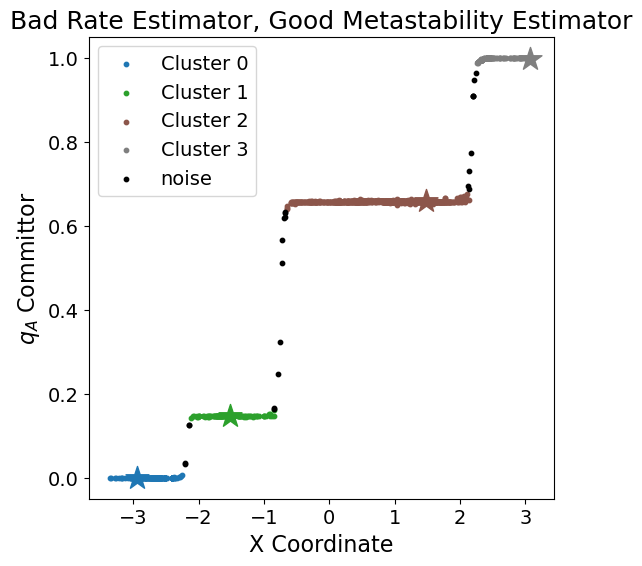

tensor([[-2.9428, -0.0838],
        [-1.5254, -0.0344],
        [ 1.4761,  0.0231],
        [ 3.0663, -0.0864]])


In [40]:
k_centers_out = []
plt.figure(figsize=(6,6))
for k in unique_labels:
    class_member_mask = (labels == k)
    q_k = q_A[class_member_mask]
    xy_k = running_xs_all[class_member_mask]
    V_xy_k = V(xy_k)
    xy_ck = xy_k[torch.argmin(V_xy_k)]
    
    if k == -1:
        # Noise
        plt.scatter(xy_k[:,0], q_k, c='k', s=10, label='noise')
    else:
        k_centers_out.append(xy_ck)
        k_mean = np.mean(q_k)
        print(k,xy_ck, k_mean)
        plt.scatter(xy_k[:,0],q_k, c=[colors(k)], s=10, label=f'Cluster {k}')
        plt.scatter(xy_ck[0],k_mean,c=colors(k),marker="*",s=300)
plt.ylabel(r"$q_A$ Committor",fontsize=16)
plt.xlabel("X Coordinate",fontsize=16)
plt.title("Bad Rate Estimator, Good Metastability Estimator",fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print(torch.stack(k_centers_out))

## Markov State Model

In [70]:
run_name = "wells_linear_5_a0_b4_K5"

In [71]:
rates = [3.52506437e-05, 3.70972579e-05, 2.27186130e-03, 6.92297970e-04, 2.00196078e-03]
transfers = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [0, 0, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 4, 2, 2, 2, 4, 2, 4, 4, 4, 2, 4, 2, 2], [1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1]]

In [72]:
import numpy as np

def build_Q(exit_rates, exit_indices):
    K = len(exit_rates)
    Q = np.zeros((K, K))
    for i, dests in enumerate(exit_indices):
        n = len(dests)
        if n:
            counts = np.bincount(dests, minlength=K)
            Q[i] = exit_rates[i] * counts / n
        Q[i, i] = -exit_rates[i]
    return Q

def mfpt_all_pairs(Q):
    K = Q.shape[0]
    M = np.zeros((K, K))
    for j in range(K):
        A = Q.copy()
        b = -np.ones(K)
        A[j, :] = 0
        A[j, j] = 1
        b[j] = 0
        M[:, j] = np.linalg.solve(A, b)
    return M


In [73]:
Q_run = build_Q(rates, transfers)
print(Q_run)

[[-3.52506437e-05  0.00000000e+00  3.52506437e-05  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -3.70972579e-05  0.00000000e+00  0.00000000e+00
   3.70972579e-05]
 [ 1.71461230e-03  0.00000000e+00 -2.27186130e-03  5.57248998e-04
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.91298853e-04 -6.92297970e-04
   3.00999117e-04]
 [ 0.00000000e+00  1.36133333e-03  0.00000000e+00  6.40627450e-04
  -2.00196078e-03]]


In [74]:
Q_run.sum(axis=1) # should be 0s

array([0., 0., 0., 0., 0.])

In [75]:
mfpt = mfpt_all_pairs(Q_run).round()
mfpt

array([[     0., 293373.,  28368., 117450., 236578.],
       [149743.,      0., 133618.,  85799.,  26956.],
       [ 16124., 265005.,      0.,  89082., 208210.],
       [ 63944., 175923.,  47819.,      0., 119128.],
       [122787.,  56795., 106662.,  58843.,      0.]])

In [76]:
print("effective rate 0->1:",f"{1/mfpt[0,1]:.2e}")
print("effective rate 1->0:",f"{1/mfpt[1,0]:.2e}")

effective rate 0->1: 3.41e-06
effective rate 1->0: 6.68e-06
